### Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

In [2]:
# Set up the dataset path
dataset_path = '.'

# Set up saving figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "InceptionResNetV2"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True) # create the sub-folders if do not exist

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

print('> SETUP Done: all saved files are accessible in ', IMAGES_PATH)

> SETUP Done: all saved files are accessible in  .\images\InceptionResNetV2


In [3]:
# Setting all the parameters or hyperparameters
img_size = 128
test_size = 0.3
random_state = 42
validation_split=0.2
epochs=30
batch_size=32
learning_rate=0.0001

### Loading & preprocessing Data

In [4]:
# DATA LOADING & PREPROCESSING
def load_and_preprocess(img_size, test_size, random_state, date):
    print('> Loading data ...')
    data = np.load(f'{dataset_path}/twri_rgb_6832_cotton_{img_size}x{img_size}_{date}.npy')
    labels = pd.read_excel(f'{dataset_path}/labels_rgb.xlsx')
    print("Shape of data images:", data.shape)
    print(f"Shape of labeled data: {labels.shape[0]}:{labels.shape[1]}, header: {labels.columns}")
    y_label = labels['class'].values

    print('> Data and labels loaded')
    print('> Preprocessing Data : remove filler class + Split train/test + Normalisation ... ')

    # Adjusting size mismatch between data and labels (chosen to cut rather than augmenting data)
    min_length = min(data.shape[0], y_label.shape[0])
    data = data[:min_length]
    y_label = y_label[:min_length]

    # Remove filler class (class 0)
    valid_idx = y_label != 0
    data = data[valid_idx]
    y_label = y_label[valid_idx] - 1  # Adjust class index to start from 0

    # Define class names
    class_names = ['rainfed', 'fully irrigated', 'percent deficit', 'time delay']
    print('Concerned classes: ', class_names)

    # Split data into train and test sets
    train_images, test_images, train_labels, test_labels = train_test_split(data, y_label, test_size=test_size, random_state=random_state)

    # Normalize images
    train_images, test_images = train_images / 255.0, test_images / 255.0

    print('> Data Preprocessing Done ')
    return train_images, test_images, train_labels, test_labels, class_names

# Execute an example
date_ex = "8_18"
train_images, test_images, train_labels, test_labels, class_names = load_and_preprocess(img_size, test_size, random_state, date_ex)

> Loading data ...
Shape of data images: (6840, 128, 128, 3)
Shape of labeled data: 6832:3, header: Index(['FID', 'treatment', 'class'], dtype='object')
> Data and labels loaded
> Preprocessing Data : remove filler class + Split train/test + Normalisation ... 
Concerned classes:  ['rainfed', 'fully irrigated', 'percent deficit', 'time delay']
> Data Preprocessing Done 


### Build & train the model
Start from a pretrained inception model (InceptionResNetV2) and customise the last layers to fit our needs

In [5]:
# MODEL BUILDING & TRAINING
def build_and_train_model(img_size, train_images, train_labels, validation_split, epochs, batch_size, learning_rate):
    print('> Building the model ... ')

    # Build the model using InceptionResNetV2
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

    # Freeze all layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(len(class_names), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print('> Training in progress ... ')
    # Train the model
    history = model.fit(train_images,
                        train_labels,
                        validation_split = validation_split,
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = 1)

    print('> End of Training !')
    return model, history

# Execute
model, history = build_and_train_model(img_size, train_images, train_labels, validation_split, epochs, batch_size, learning_rate)
#model.summary()

> Building the model ... 

> Training in progress ... 
Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 70s 588ms/step - accuracy: 0.2898 - loss: 1.7509 - val_accuracy: 0.4064 - val_loss: 1.2655
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.3713 - loss: 1.3673 - val_accuracy: 0.4980 - val_loss: 1.1554
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.4085 - loss: 1.2756 - val_accuracy: 0.5086 - val_loss: 1.1267
Epoch 4/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.4336 - loss: 1.2271 - val_accuracy: 0.5073 - val_loss: 1.1100
Epoch 5/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.4747 - loss: 1.1704 - val_accuracy: 0.5405 - val_loss: 1.0701
Epoch 6/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.4921 - loss: 1.1411 - val_accuracy: 0.5458 - val_loss: 1.0548
Epoch 7/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.4854 - loss: 1.1296 - val_accuracy: 0.5511 - val_loss: 1.0397
Epoch 8/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - a

### Evaluating the Model

> Lets evaluate the model now ... 


<>:22: SyntaxWarning: invalid escape sequence '\C'
<>:22: SyntaxWarning: invalid escape sequence '\C'
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11096\1116904636.py:22: SyntaxWarning: invalid escape sequence '\C'
  report_path = f"{IMAGES_PATH}\Classification_Report_{date}.txt"


51/51 - 29s - 574ms/step - accuracy: 0.6466 - loss: 0.8588
Test Accuracy for 8_18: 0.65
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 699ms/step
Saving figure Confusion_matrix_8_18
                 precision    recall  f1-score   support

        rainfed       0.69      0.84      0.76       424
fully irrigated       0.71      0.76      0.74       399
percent deficit       0.58      0.37      0.45       404
     time delay       0.57      0.61      0.59       386

       accuracy                           0.65      1613
      macro avg       0.64      0.64      0.63      1613
   weighted avg       0.64      0.65      0.63      1613

Saving figure Training_Accuracy_8_18


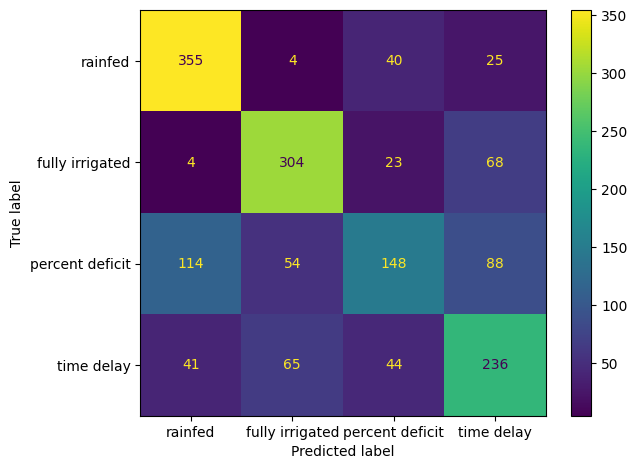

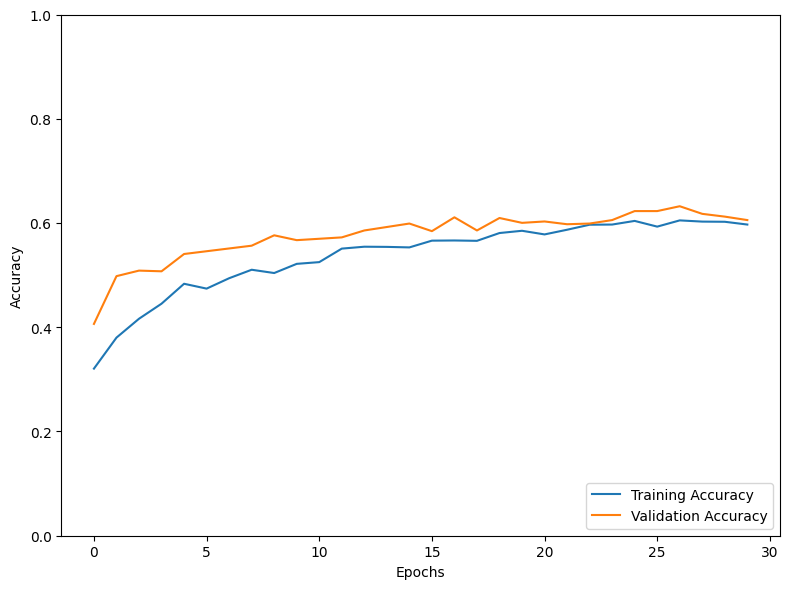

In [6]:
# MODEL EVALUATION
def evaluate_model(model, test_images, test_labels, date, history):
    print('> Let''s evaluate the model now ... ')

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
    print(f"Test Accuracy for {date}: {test_acc:.2f}")

    # Predictions and classification report
    predictions = model.predict(test_images)
    pred_classes = np.argmax(predictions, axis=1)

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(test_labels, pred_classes, display_labels=class_names)
    save_fig(f"Confusion_matrix_{date}")

    # Classification report
    report = classification_report(test_labels, pred_classes, target_names=class_names)
    print(report)

    # Save the classification report
    report_path = f"{IMAGES_PATH}\Classification_Report_{date}.txt"
    with open(report_path, "w") as f:
        f.write(report)

    # Plot training history
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    save_fig(f"Training_Accuracy_{date}")

evaluate_model(model, test_images, test_labels, date_ex, history)

### Global Process
Building over many datasets accross 4 sampling dates: August 18th, September 2nd, September 9th, September 20th 

In [ ]:
# GLOBAL PROCESS: Building over many datasets accross 4 sampling dates

for date in ["8_18", "9_02", "9_09", "9_20"]:
  print(f'\nDATE SAMPLING {date} :')
  train_images, test_images, train_labels, test_labels, class_names = load_and_preprocess(img_size, test_size, random_state, date)
  model, history = build_and_train_model(img_size, validation_split, epochs, batch_size)
  evaluate_model(model, test_images, test_labels, date, history)

# End of script